<h2><u>Pengembangan Aplikasi <i>Speech-to-text</i> Bahasa Indonesia Dengan Arsitektur Transformer Terutilisasi</u></h2>
<b>Dr. Rizka Wakhidatus Sholikah, S.Kom.*</b><br>
<i>Departemen Teknologi Informasi, Institut Teknologi Sepuluh Nopember Surabaya</i>

<b>Kevin Putra Santoso</b><br>
<i>Departemen Teknologi Informasi, Institut Teknologi Sepuluh Nopember Surabaya</i>

<b>Mohammad Idris Arif Budiman</b><br>
<i>Departemen Teknik Informatika, Institut Teknologi Sepuluh Nopember Surabaya</i>

Dalam proyek ini, kami mencoba menerapkan arsitektur Transformer yang terinspirasi dari paper **Attention is All You Need** (oleh Google Brain) dan arsitektur **Whisper** dari OpenAI untuk melakukan Automatic Speech Recognition dalam bahasa Indonesia. Data yang digunakan dalam proyek ini adalah Mozilla Common Voice untuk bahasa Indonesia.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import string

from models.transformer import Transformer
from ops.scheduler import Scheduler
from ops.preprocess_data import PreprocessData
from ops.base_functions import conv_char2num, conv_num2char
from ops.loss import SmoothCTC_CrossEntropyLoss
import warnings
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings('ignore')

In [2]:
df1  = pd.read_csv('./dataset/common_voice_id/train.tsv', sep='\t')
df2 = pd.read_csv('./dataset/common_voice_id/validated.tsv', sep='\t')
df3 = pd.read_csv('./dataset/common_voice_id/test.tsv', sep='\t')

df1 = df1[['path', 'sentence']]
df2 = df2[['path', 'sentence']]
df3 = df3[['path', 'sentence']]

df = pd.concat([df1, df2, df3], ignore_index=True)
df = df.sample(frac=1, random_state=42)
df = df.reset_index(drop=True)

In [3]:
print(df.shape)
df_testing = df[:1000]
print(df_testing.shape)

(33808, 2)
(1000, 2)


In [4]:
def remove_strips(text):
    cleaned_text = text.replace('“', '')
    cleaned_text = cleaned_text.replace('”', '')
    cleaned_text = cleaned_text.replace('‘', '')
    cleaned_text = cleaned_text.replace('’', '')
    cleaned_text = cleaned_text.replace(',', ' ')
    cleaned_text = cleaned_text.replace('-', ' ')
    cleaned_text = cleaned_text.replace("'", '')
    cleaned_text = cleaned_text.replace("—", '')
    cleaned_text = cleaned_text.replace("–", '')
    cleaned_text = cleaned_text.replace("，", ' ')
    cleaned_text = cleaned_text.replace(".", ' ')
    cleaned_text = cleaned_text.replace("á", 'a')
    cleaned_text = cleaned_text.replace("é", 'e')
    cleaned_text = cleaned_text.replace("0", 'nol')
    cleaned_text = cleaned_text.replace("1", 'satu')
    cleaned_text = cleaned_text.replace("2", 'dua')
    cleaned_text = cleaned_text.replace("3", 'tiga')
    cleaned_text = cleaned_text.replace("4", 'empat')
    cleaned_text = cleaned_text.replace("5", 'lima')
    cleaned_text = cleaned_text.replace("6", 'enam')
    cleaned_text = cleaned_text.replace("7", 'tujuh')
    cleaned_text = cleaned_text.replace("8", 'delapan')
    cleaned_text = cleaned_text.replace("9", 'sembilan')
    cleaned_text = cleaned_text.replace("[", '')
    cleaned_text = cleaned_text.replace("]", '')
    cleaned_text = cleaned_text.replace("\\", '')
    cleaned_text = cleaned_text.replace("！", '')
    cleaned_text = cleaned_text.strip(string.punctuation)
    return cleaned_text

for i in range(len(df_testing['sentence'])):
    df_testing['sentence'][i] = df_testing['sentence'][i].lower()
    df_testing['sentence'][i] = ' '.join(word.strip(string.punctuation) for word in df_testing['sentence'][i].split())
    df_testing['sentence'][i] = ' '.join(remove_strips(word) for word in df_testing['sentence'][i].split())

In [5]:
label_list = []
HOME = os.getcwd()
for i in range(len(df_testing)):
    os.system(f'copy \"{HOME}\\dataset\\common_voice_id\\clips\\{df_testing["path"][i]}\" \"{HOME}\\dataset\\audio_folder\\{df_testing["path"][i]}\"')
    label_list.append(df_testing['sentence'][i])

In [6]:
print(f'Banyaknya label: {len(label_list)}')
print('Sampel 5 label')
label_list[:5]

Banyaknya label: 1000
Sampel 5 label


['saya lebih suka ikan daripada daging',
 'walaupun sudah pukul dua belas malam saya tetap belajar',
 'kalau begitu sampai jumpa lagi',
 'tidak boleh masuk kamar ini',
 'kekosongan konstituensi dapat diisi oleh pemilihan sela']

## Sekilas Terkait Data
Dataset yang akan kita latih diharapkan memiliki format sebagai berikut.

```python
[[tensor_1], [transcription_1],
 [tensor_2], [transcription_2],
 ...
 [tensor_n], [transcription_n]]
```

Untuk itu modul ```Dataset``` oleh PyTorch dapat digunakan untuk membuat dataset ini. Modul ini dipanggil dengan syntax

```python
from torch.utils.data import Dataset
```

dengan ukuran batch (batch size) sebesar 64.

tensor_i adalah tensor yang memuat matriks Log Mel Spectogram dari sebuah audio. Meninjau ulang bahwa sebuah matriks Log Mel Spectogram memiliki ukuran ```(n_mel, timesteps)``` dengan ```n_mel=64``` dan timesteps bergantung dari audio yang memiliki durasi terpanjang (timesteps tidak sama dengan durasi audio).

transcription_i adalah tensor yang memuat transkripsi yang telah di encode menjadi angka dalam dictionary encoder yang ditentukan oleh user (biasa disebut sebagai vocabulary). tensor ini memiliki ukuran ```(1, max_len)``` dimana ```max_len``` adalah transkripsi terpanjang dari sebuah audio. Perlu diingat bahwa panjang transkripsi maksimum akan dibatasi sebesar 256.

In [7]:
# Tes conv_char2num dan conv_num2char
example_text = 'Saya berangkat ke sekolah di pagi hari'
numeric_representation = conv_char2num(example_text)
print('Representasi Numerik (dengan padding):')
print(numeric_representation)
print('Invers: ')
print(conv_num2char(numeric_representation))

Representasi Numerik (dengan padding):
[ 2 22  4 28  4  1  5  8 21  4 17 10 14  4 23  1 14  8  1 22  8 14 18 15
  4 11  1  7 12  1 19  4 10 12  1 11  4 21 12  3  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
Invers: 
<saya berangkat ke sekolah di pagi hari>


In [8]:
def split_data(df, split_point=0.8):
    data_size = len(df)
    df = df.sample(frac=1).reset_index(drop=True)
    split = int(split_point * data_size)
    df_train, df_valid = df[:split], df[split:]
    df_train
    
    return df_train, df_valid.reset_index(drop=True)

df_train, df_valid = split_data(df_testing)

In [9]:
# Copy train audio data to 'train' folder
label_list_train = []

for i in range(len(df_train)):
    os.system(f'move \"{HOME}\\dataset\\audio_folder\\{df_train["path"][i]}\" \"{HOME}\\dataset\\audio_folder\\train\\{df_train["path"][i]}\"')
    label_list_train.append(df_train['sentence'][i])

In [10]:
# Copy validation audio data to 'valid' folder
label_list_valid = []

for i in range(len(df_valid)):
    os.system(f'move \"{HOME}\\dataset\\audio_folder\\{df_valid["path"][i]}\" \"{HOME}\\dataset\\audio_folder\\valid\\{df_valid["path"][i]}\"')
    label_list_valid.append(df_valid['sentence'][i])

## Preprocessing dan Load Data
Untuk melakukan preprocessing data, perangkat alam menjadi faktor utama yang perlu dikonsiderasi. Untuk menghindari crash atau memory overleak, akan lebih baik jika preprocessing dilakukan dengan sistem batch. Dengan kata lain, kita perlu membuat data loader khusus audio lalu menggunakan data loader dengan batch tertentu untuk melatih model kita agar alokasi memori tidak berlebihan.

In [11]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, audio_dir, transcription_df, hyperplane_threshold):
        self.preprocess_data = PreprocessData(audio_dir, transcription_df, hyperplane_threshold, return_metadata = False)
        self.spectograms, self.transcripts = self.preprocess_data.load()
        self.spectograms = self.spectograms.to(device)
        self.transcripts = self.transcripts.to(device)

    def __len__(self):
        return len(self.spectograms)

    def __getitem__(self, idx):
        return self.spectograms[idx], self.transcripts[idx]


Mounted audio directory at:  ./dataset/audio_folder/train/
Counter on 218, error on common_voice_id_25956690.mp3
Counter on 413, error on common_voice_id_26237258.mp3
Counter on 470, error on common_voice_id_25969772.mp3
Counter on 565, error on common_voice_id_22951185.mp3
Counter on 722, error on common_voice_id_26229412.mp3
Counter on 783, error on common_voice_id_26228004.mp3


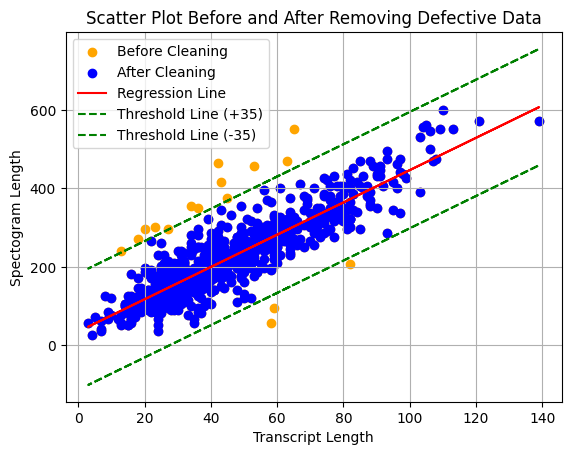

Mounted audio directory at:  ./dataset/audio_folder/valid/
Counter on 76, error on common_voice_id_19493226.mp3


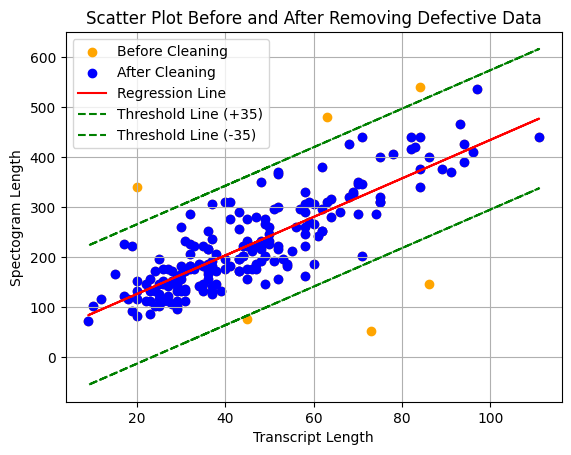

In [12]:
train_dataset = AudioDataset('./dataset/audio_folder/train/', df_train, 35)
valid_dataset = AudioDataset('./dataset/audio_folder/valid/', df_valid, 35)

train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 64, shuffle = True)

## Persiapan Model, Optimizer, dan Scheduler Untuk Transformer

Dalam percobaan training ini, kami menggunakan jumlah n_embedding sebanyak 192. Angka ini kami tetapkan atas konsiderasi mengenai banyaknya kosakata yang mungkin tersusun dalam bahasa Indonesia. Jumlah attention head, layer feed-forward network, layer encoder, dan layer decoder pun ditetapkan default dengan konfigurasi (4, 400, 8, 5).

In [13]:
model = Transformer(num_hid = 192,
                    num_head = 4,
                    num_feed_forward = 400,
                    num_layers_enc = 8,
                    num_layers_dec = 5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = 1e-5)
scheduler = Scheduler(optimizer, steps_per_epoch=len(train_dataloader))
ctc_ce_loss = SmoothCTC_CrossEntropyLoss(smoothing = 0.1)

## Proses Training

In [14]:
from IPython import display
from tqdm import tqdm
from jiwer import wer
import re

start_token_id = 2
end_token_id = 3

def train_step(model, optimizer, batch):
    source = batch[0]
    target = batch[1]
    dec_input = target[:, :-1]
    dec_target = target[:, 1:]

    optimizer.zero_grad()

    preds = model([source, dec_input])
    loss = ctc_ce_loss(preds, dec_target)
    loss.backward()
    optimizer.step()

    return {"Loss": loss.item()}

def validate(model, validation_set):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for batch in validation_set:
            source = batch[0]
            target = batch[1]
            dec_input = target[:, :-1]
            dec_target = target[:, 1:]
            
            preds = model([source, dec_input])
            loss = ctc_ce_loss(preds, dec_target)
            total_loss += loss.item()
    
    return total_loss / len(validation_set)
    

In [ ]:
num_epochs = 10000
lowest_wer = float('inf')

for epoch in range(num_epochs):
    model.train()
    epoch_loss, total_wer, avg_wer = 0, 0, 0

    for batch_src, batch_tgt in tqdm(train_dataloader, desc = f"Training on Epoch {epoch + 1} ", leave = False):
        loss = train_step(model, optimizer, [batch_src, batch_tgt])
        epoch_loss += loss['Loss']
    
    avg_epoch_loss = epoch_loss / len(train_dataloader)
    validation_loss = validate(model, valid_dataloader)
    display.clear_output(wait = True)

    ground_truths = []

    for batch_tgt_item in batch_tgt:
        ground_truths.append(conv_num2char(batch_tgt_item.cpu().numpy()))
    
    prediction = model.generate(batch_src, start_token_id)

    for id, item in enumerate(prediction):
        prediction_text = conv_num2char(item.detach().cpu().numpy())
        matches = re.findall(r'<[a-zA-Z\s]+>', prediction_text)
        cleaned_text = matches[0] if matches else None
        try:
            print(f"Ground truth {id} => ", ground_truths[id])
            print(f"Generation {id}   => ", cleaned_text)
            total_wer += wer(ground_truths[id], cleaned_text)
            avg_wer = total_wer / len(ground_truths)
        except:
            print("Ada kesalahan saat menghitung WER")
        
        print('-------------------------------------------------------------------------')
    
    if epoch % 5 == 0:
        print("===============================================================================")
        print(f"Epoch [{epoch+1}/{num_epochs}], Mean Loss: {avg_epoch_loss:.4f}")
        print(f"Validation Loss : {validation_loss:.4f}")
        print(f"WER Score       : {avg_wer}")
        print(f"Lowest WER      : {lowest_wer}")
        print("===============================================================================")
        print("Ground truth : ", ground_truths[id])
        print("Generation   : ", cleaned_text)
        print("===============================================================================")
    
    scheduler.step()

    if avg_wer < lowest_wer:
        lowest_wer = avg_wer
        torch.save(model, './config/best_wer_model.pth')